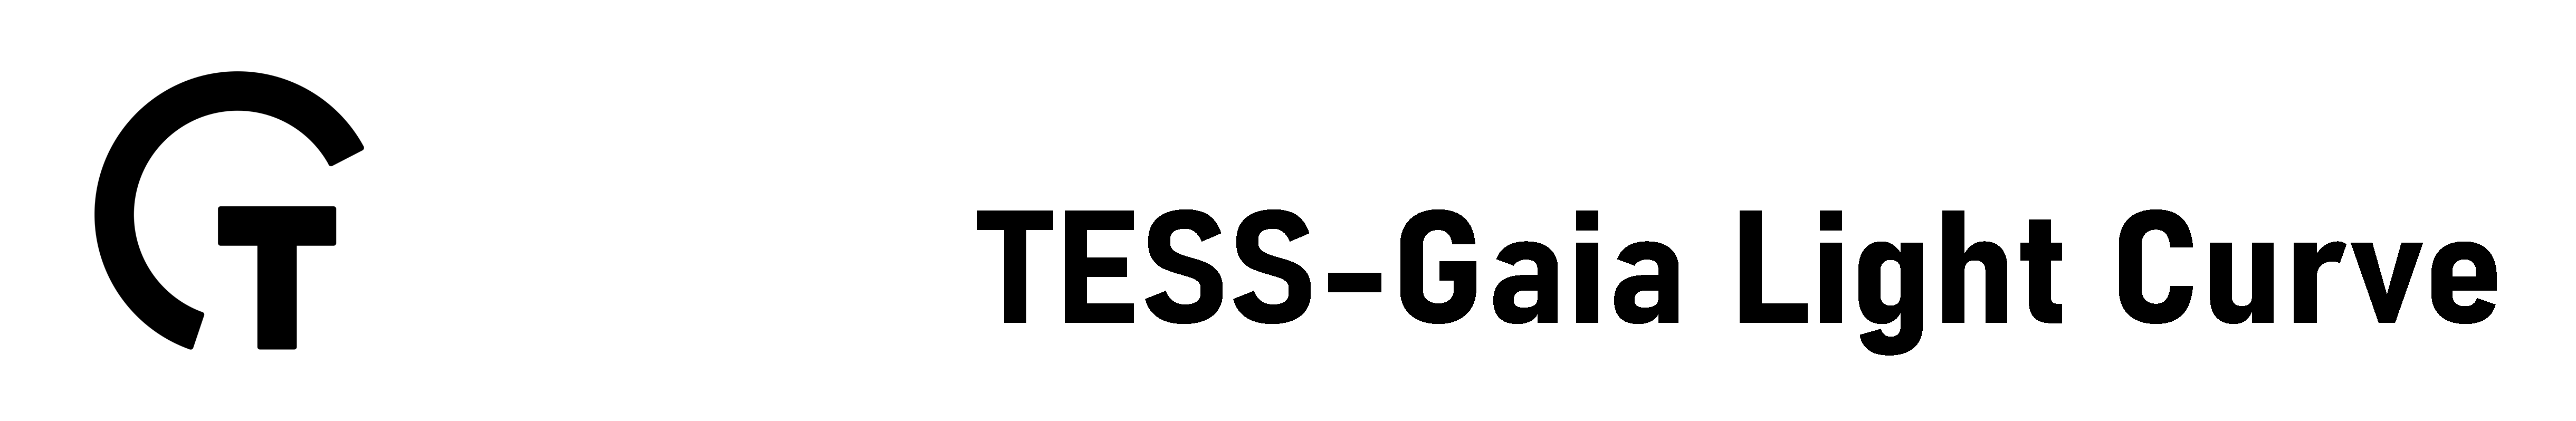

TESS-Gaia Light Curve (TGLC) is a dataset of TESS full-frame image light curves publicly available via the MAST portal. It is fitted with effective PSF and decontaminated with Gaia DR2 and achieved percent-level photometric precision down to 16th magnitude! It unlocks astrophysics to a vast number of dim stars below 12th magnitude. Here we introduce the basic data structure of our light curves and show simple analysis. 

# 1. Obtain Light curves

There are two ways to get the light curves: 
### 1.1 Download from the MAST Portal
The sectors are slowly [updated](https://docs.google.com/spreadsheets/d/1FhHElWb1wmx9asWiZecAJ2umN0-P_aXn55OBVB34_rg/edit?usp=sharing) on MAST Portal due to the limited ingestion speed. In [MAST Portal](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html), choose advanced search and in Provenance Name, choose TGLC.  

Or, you can use the `astroquery.mast` package to query in python. Please refer to [astroquery.mast](https://astroquery.readthedocs.io/en/latest/mast/mast.html) for full documentary. To limit your query to TGLC, specify provenance_name='TGLC'

In [1]:
from astroquery.mast import Observations

obs_table = Observations.query_criteria(target_name='389023759', # TIC
                                        provenance_name='TGLC')

data_products = Observations.get_product_list(obs_table)
print(obs_table) 

product = data_products[0]["dataURI"] # download the first light curve if multiple lcs are returned
result = Observations.download_file(product) # check obs_table['target_name'], which is the TIC ID


intentType obs_collection provenance_name ... srcDen   obsid     objID  
---------- -------------- --------------- ... ------ --------- ---------
   science           HLSP            TGLC ...    nan 107964294 200117913
INFO: Found cached file /Users/tehan/PycharmProjects/TESS_Gaia_Light_Curve/tutorial/hlsp_tglc_tess_ffi_gaiaid-6399196263939178880-s0001-cam2-ccd1_tess_v1_llc.fits with expected size 57600. [astroquery.query]


Please refer to Section 2 and 3 for using the fits file. 

### 1.2 Fit with the package `tglc`. (SKIP THIS IF YOU DOWNLOADED DATA FROM MAST)

First install `tglc` with [pip](https://pypi.org/project/tglc/) : `pip install tglc`. Require python version 3.8.0 or newer.

In [2]:
import tglc
tglc.__version__

'0.7.0'

The version of this tutorial uses tglc version 0.6.0, please make sure your version is up-to-date. Let's start with fitting the first sector this star was observed in. Some of the output light curve of this tutorial is included in the tutorial folder for comparison. 

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tglc.quick_lc import tglc_lc

target = 'TIC 218795833'     # TIC ID (preferred, 'TIC 12345678'), Target ID ('TOI 519') or coordinates ('ra dec')
local_directory = f'{target}/'    # directory to save all files
os.makedirs(local_directory, exist_ok=True)
tglc_lc(target=target, 
        local_directory=local_directory, # directory to output everything
        size=90, # FFI cutsize. Recommand at least 50 or larger for better performance. Cannot exceed 99. 
                 # Downloading FFI might take longer (or even cause timeouterror) for larger sizes. 
        save_aper=True, # whether to save 5*5 pixels timeseries of the decontaminated images in fits file primary HDU
        limit_mag=15, # the TESS magnitude lower limit of stars to output
        get_all_lc=False, # whether to return all lcs in the region. If False, return the nearest star to the target coordinate
        first_sector_only=True, # whether to return only lcs from the sector this target was first observed. 
                                # If False, return all sectors of the target, but too many sectors could be slow to download.
        last_sector_only=False, # whether to return only lcs from the sector this target was last observed. 
        sector=None, # If first_sector_only = True or last_sector_only = True and type(sector) != int, return first or last sector.
                     # If first(last)_sector_only=False and sector = None, return all observed sectors
                     # If first(last)_sector_only=False and type(sector) == int, return only selected sector. 
                     # (Make sure only put observed sectors. All available sectors are printed in the sector table.)
        prior=None,  # If None, does not allow all field stars to float. SUGGESTED for first use. 
                     # If float (usually <1), allow field stars to float with a Gaussian prior with the mean 
                     # at the Gaia predicted value the width of the prior value multiplied on the Gaia predicted value.
        transient=None, # If generating light curve at an arbitrary RA and Dec, set this to [`name', `RA', `DEC'].
                        # Make sure target = 'RA Dec'
        ffi='SPOC',  #  The FFI version used; 'SPOC' is default. 'TICA' is experimental.
        )

Target: TIC 218795833
  sectorName   sector camera ccd
-------------- ------ ------ ---
tess-s0007-2-3      7      2   3
tess-s0008-2-4      8      2   4
tess-s0034-2-3     34      2   3
tess-s0061-2-3     61      2   3
tess-s0088-2-3     88      2   3
Found 5 sector(s) for this target.
Resolving TIC -> Gaia DR3 designation via TAP ... done in 4.9s.   
DR2 source_id: 5707485527450614656; DR3 designation: Gaia DR3 5707485527450614656
Only processing the first sector the target is observed in: Sector 7.
MAST Tesscut timeout set to 3600s.
MAST Tesscut timeout set to 3600s.
Target Gaia: Gaia DR2 5707485527450614656
Querying Gaia DR3 cone search ...INFO: Query finished. [astroquery.utils.tap.core]
Querying Gaia DR3 cone search ... done in 10.3s.   
Found 20172 Gaia DR3 objects.
Querying TIC around target ... done in 15.1s.   
Found 1501 TIC objects.
Crossmatching TIC -> Gaia DR3 (this may take a while) ...INFO: Query finished. [astroquery.utils.tap.core]
Crossmatching TIC -> Gaia DR3 (this 

Fitting lc: 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


This could take a while to download depending on the cutsize. Once finished, you get the light curves you asked and can check the FFI cut and the effective PSF shape.

### 1.3 FFI cut and ePSF
Note the ePSF is twice oversampled in this plot. 

sector = 7


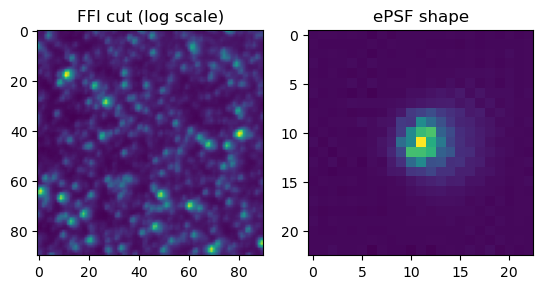

In [5]:
import pickle
with open(f'{local_directory}source/source_SPOC_TIC 218795833_sector_7.pkl', 'rb') as input_: # replace with each sector's .pkl file if you have more than the first sector
    source = pickle.load(input_)
    print(f'sector = {source.sector}')
epsf = np.load(f'{local_directory}epsf/epsf_TIC 218795833_sector_7.npy')

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(np.log10(source.flux[0]))
ax1.set_title('FFI cut (log scale)')
ax2.imshow(epsf[0,:23**2].reshape(23,23))
ax2.set_title('ePSF shape')
plt.show()
# print(source.gaia[:5]) # all the gaia stars 
# print(source.tic[:5]) # TIC ID to Gaia DR2 conversion

### 1.4 Variability source identification plot

In [6]:
%matplotlib inline
from tglc.quick_lc import plot_contamination
plot_contamination(local_directory=local_directory,  # directory to output everything
                   gaia_dr3=5707485527450614656,  # Gaia DR3 ID for the target to analyze
                   ymin=None, # manually set ymin of pixel fluxes,
                   ymax=None, # manually set ymax of pixel fluxes,
                   pm_years=3000 # determines the proper motion arrow length of equivalent years
                   )

Already in sector 7.
Interquartile Range (IQR): 0.0694825545111426
Standard Deviation: 0.14771349027268157


If you would like to get all sectors of light curves for this target, you may run the following:

In [17]:
tglc_lc(target=target, local_directory=local_directory, size=90, save_aper=True, limit_mag=15, 
        get_all_lc=False, first_sector_only=False, sector=None, prior=None)  

Target: TIC 218795833
  sectorName   sector camera ccd
-------------- ------ ------ ---
tess-s0007-2-3      7      2   3
tess-s0008-2-4      8      2   4
tess-s0034-2-3     34      2   3
tess-s0061-2-3     61      2   3
tess-s0088-2-3     88      2   3
Found 5 sector(s) for this target.
Resolving TIC -> Gaia DR3 designation via TAP ... done in 5.4s.   
DR2 source_id: 5707485527450614656; DR3 designation: Gaia DR3 5707485527450614656
Processing all available sectors of the target.
MAST Tesscut timeout set to 3600s.
################################################
  sectorName   sector camera ccd
-------------- ------ ------ ---
tess-s0007-2-3      7      2   3
tess-s0008-2-4      8      2   4
tess-s0034-2-3     34      2   3
tess-s0061-2-3     61      2   3
tess-s0088-2-3     88      2   3
Loaded ffi_cut from directory. 
Loaded ePSF TIC 218795833 from directory. 


Fitting lc: 100%|██████████| 1/1 [00:00<00:00, 15.96it/s]

################################################
MAST Tesscut timeout set to 3600s.


Target Gaia: Gaia DR2 5707485527450614656
Querying Gaia DR3 cone search ...INFO: Query finished. [astroquery.utils.tap.core]
Querying Gaia DR3 cone search ... done in 11.5s.   
Found 20172 Gaia DR3 objects.
Querying TIC around target ... done in 0.6s.   
Found 1501 TIC objects.
Crossmatching TIC -> Gaia DR3 (this may take a while) ...INFO: Query finished. [astroquery.utils.tap.core]
Crossmatching TIC -> Gaia DR3 (this may take a while) ... done in 4.8s.   
Requesting Tesscut cutouts (sector 8). Waiting on MAST response (later sectors with 200s cadence can take ~20 minutes) ... done in 70.1s.   


Fitting ePSF: 100%|██████████| 968/968 [00:51<00:00, 18.66it/s]
/opt/miniconda3/envs/TESS_Gaia_Light_Curve/lib/python3.10/site-packages/tglc/target_lightcurve.py:275: UserWarning: TESS FFI cut includes Nan values. Please shift the center of the cutout to remove Nan near edge. Target: TIC 218795833
  warnings.warn(
Fitting lc: 100%|██████████| 1/1 [00:00<00:00, 18.31it/s]


################################################
MAST Tesscut timeout set to 3600s.
Target Gaia: Gaia DR2 5707485527450614656
Querying Gaia DR3 cone search ...INFO: Query finished. [astroquery.utils.tap.core]
Querying Gaia DR3 cone search ... done in 12.1s.   
Found 20172 Gaia DR3 objects.
Querying TIC around target ... done in 13.3s.   
Found 1501 TIC objects.
Crossmatching TIC -> Gaia DR3 (this may take a while) ...INFO: Query finished. [astroquery.utils.tap.core]
Crossmatching TIC -> Gaia DR3 (this may take a while) ... done in 10.9s.   
Requesting Tesscut cutouts (sector 34). Waiting on MAST response (later sectors with 200s cadence can take ~20 minutes) ... done in 457.5s.   


KeyboardInterrupt: 

# 2. Data structure

In [10]:
from astropy.io import fits
hdul_s007 = fits.open('TIC 218795833/lc/hlsp_tglc_tess_ffi_gaiaid-5707485527450614656-s0007-cam2-ccd3_tess_v2_llc.fits')
hdul_s007.info()

Filename: TIC 218795833/lc/hlsp_tglc_tess_ffi_gaiaid-5707485527450614656-s0007-cam2-ccd3_tess_v2_llc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      41   (5, 5, 1093)   float32   
  1  LIGHTCURVE    1 BinTableHDU     59   1093R x 9C   [D, E, E, E, E, E, J, I, I]   
  2                1 ImageHDU         8   (5, 5, 3)   float64   


The naming of tglc light curves follows the structure:
hlsp_tglc_tess_ffi_gaiaid-{Gaia DR3 ID}-s{sector}-cam{camera No.}-ccd{CCD No.}_tess_v1_llc.fits

Each light curve fits file has two HDUs: the Primary HDU is a 5\*5 pixels cut around the star (will be empty if you downloaded from MAST); the Second HDU contains the light curves. 

If you saved the decontaminated image (save_aper=True), you can access the 5\*5 pixels time series of decontaminted images. This is useful for making light curves with arbitrary apeture shapes. 

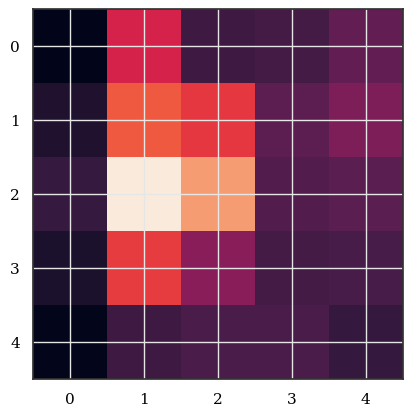

In [11]:
aperture_sequence = hdul_s007[0].data
plt.imshow(aperture_sequence[0])

# 3. Exoplanet example
Below are the raw light curves of TOI-519 (TIC 218795833), which we produced above. It is known to host an exoplanet, and it is very faint (14.5 TESS mag).  Note: The following light curves are made with 150x150 FFIcut (These are/will be published on MAST). You may compare them to the light curves we made in Section 1 with 90x90 pixels. 

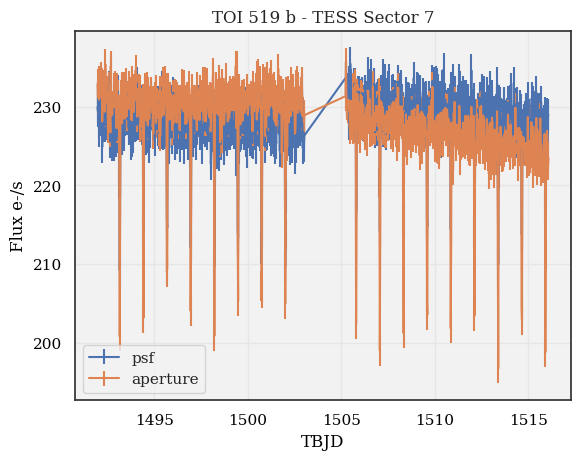

In [12]:
q_07 = [a and b for a, b in zip(list(hdul_s007[1].data['TESS_flags'] == 0),
                                list(hdul_s007[1].data['TGLC_flags'] == 0))]
# filter out bad datapoints from both TESS FFI flags and TGLC flags

time_07 = hdul_s007[1].data['time'][q_07]
psf_flux_07 = hdul_s007[1].data['psf_flux'][q_07] # raw psf flux
psf_flux_err_07 = hdul_s007[1].header['PSF_ERR'] # raw psf flux error
aper_flux_07 = hdul_s007[1].data['aperture_flux'][q_07] # raw aper flux
aper_flux_err_07 = hdul_s007[1].header['APER_ERR'] # raw aper flux error
plt.errorbar(time_07, psf_flux_07, psf_flux_err_07, marker = '', label = 'psf')
plt.errorbar(time_07, aper_flux_07, aper_flux_err_07, marker = '', label = 'aperture')
plt.title('TOI 519 b - TESS Sector 7')
plt.xlabel('TBJD')
plt.ylabel('Flux e-/s')
plt.legend()
plt.show()

Note that the two light curves have the same median flux levels. While the raw aperture flux only sums a 3\*3 pixel region around the star, which is not 100\% of the flux from the star, we account for this by normalizing by the PSF shape. 

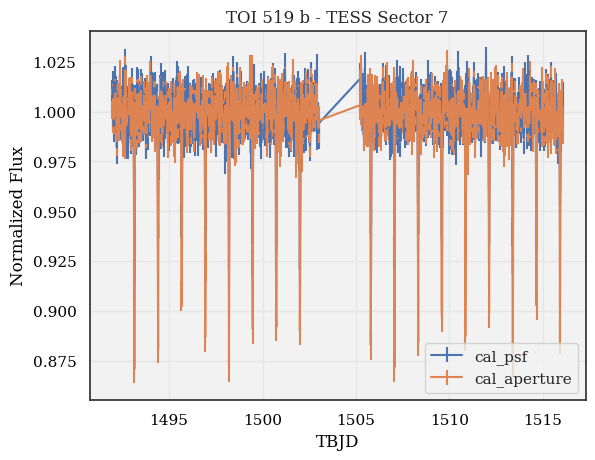

In [13]:
cal_psf_flux_07 = hdul_s007[1].data['cal_psf_flux'][q_07] # calibrated psf flux
cal_psf_flux_err_07 = hdul_s007[1].header['CPSF_ERR'] # calibrated psf flux error
cal_aper_flux_07 = hdul_s007[1].data['cal_aper_flux'][q_07] # calibrated aper flux
cal_aper_flux_err_07 = hdul_s007[1].header['CAPE_ERR'] # calibrated aper flux error
plt.errorbar(time_07, cal_psf_flux_07, cal_psf_flux_err_07, marker = '', label = 'cal_psf')
plt.errorbar(time_07, cal_aper_flux_07, cal_aper_flux_err_07, marker = '', label = 'cal_aperture')
plt.title('TOI 519 b - TESS Sector 7')
plt.xlabel('TBJD')
plt.ylabel('Normalized Flux')
plt.legend()
plt.show()

We can also crossmatch different sectors of the same star. TOI-519 has been observed by TESS for 5 times until Feb 2026. We will bin all sectors to 30-min for fair comparison. Be careful since the primary mission (1-26), 1st extended mission (27-55), and 2nd extended mission (56-) each have different cadence (1800s, 600s, and 200s).  Note: We only show the first three sectors, try the last sector (61) on your own!

In [ ]:
hdul_s008 = fits.open('hlsp_tglc_tess_ffi_gaiaid-5707485527450614656-s0008-cam2-ccd4_tess_v2_llc.fits')
q_08 = [a and b for a, b in zip(list(hdul_s008[1].data['TESS_flags'] == 0),
                                list(hdul_s008[1].data['TGLC_flags'] == 0))]
time_08 = hdul_s008[1].data['time'][q_08]
cal_aper_flux_08 = hdul_s008[1].data['cal_aper_flux'][q_08]  # calibrated aperture flux
cal_aper_flux_err_08 = hdul_s008[1].header.get('CAPER_ERR', hdul_s008[1].header['CPSF_ERR'])

hdul_s034 = fits.open('hlsp_tglc_tess_ffi_gaiaid-5707485527450614656-s0034-cam2-ccd3_tess_v2_llc.fits')
q_34 = [a and b for a, b in zip(list(hdul_s034[1].data['TESS_flags'] == 0),
                                list(hdul_s034[1].data['TGLC_flags'] == 0))]
# binning
time_34 = hdul_s034[1].data['time'][q_34]
time_34 = np.mean(time_34[:len(time_34) // 3 * 3].reshape(-1, 3), axis=1)
cal_aper_flux_34 = hdul_s034[1].data['cal_aper_flux'][q_34]  # calibrated aperture flux
cal_aper_flux_34 = np.mean(cal_aper_flux_34[:len(cal_aper_flux_34) // 3 * 3].reshape(-1, 3), axis=1)
cal_aper_flux_err_34 = hdul_s034[1].header.get('CAPER_ERR', hdul_s034[1].header['CPSF_ERR']) / np.sqrt(3)


FileNotFoundError: [Errno 2] No such file or directory: 'hlsp_tglc_tess_ffi_gaiaid-5707485527450614656-s0008-cam2-ccd4_tess_v2_llc.fits'

NameError: name 'time_08' is not defined

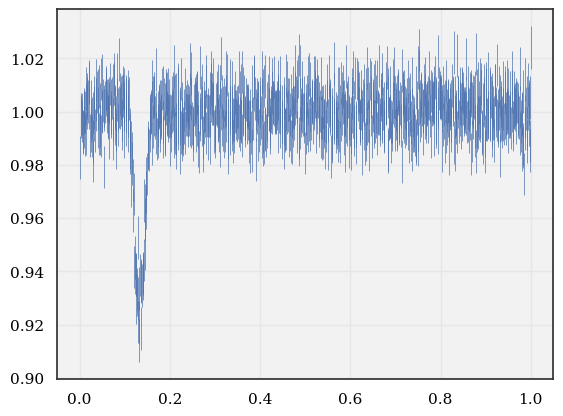

In [16]:
period = 1.2652328
plt.errorbar(time_07 % period / period, cal_aper_flux_07, cal_aper_flux_err_07, marker = '', lw=0.5, ls = '', label = 'S07')
plt.errorbar(time_08 % period / period, cal_aper_flux_08, cal_aper_flux_err_08, marker = '', lw=0.5, ls = '', label = 'S08')
plt.errorbar(time_34 % period / period, cal_aper_flux_34, cal_aper_flux_err_34, marker = '', lw=0.5, ls = '', label = 'S34')
plt.title('TOI 519 b - Calibrated aperture flux')
plt.xlabel('Phase')
plt.ylabel('Flux e-/s')
plt.legend()
plt.show()


The two flags take out the majority of bad datapoints, although several outliers remain. We can see a consistant transit depth among three sectors (correct dilution), an indication of the robustness of tglc.